# Washington State Hike Data
Emily Grabowski

Notebook to process and visualize Washington Trail Association data on hikes in Washington State. Trip report counts have been shown to strongly correlate with traffic at trails (source: https://www.wta.org/news/magazine/features/better-data-better-trails). Usomg report counts as a metric for popularity, this notebook explores the WTA trail dataset. Data from wta.org (scraped using: https://github.com/yoshiohasegawa/wta-scraper).

**Goal**: Explore the patterns in report counts (as a metric of hike popularity) and other properties of the WTA hike dataset.

## Data

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from scipy.spatial import cKDTree
import itertools
from operator import itemgetter
import statsmodels.api as sm

In [2]:
#set some default plot parameters
sns.set(font_scale=2,style='white')
plt.rcParams['figure.figsize'] = [20, 10] #make default plot larger

In [3]:
#read in scraped data
df = pd.read_csv("2021-03-29_wta_hike_data.csv")
print('There are', df.shape[0], 'hikes in the dataset')
df.head()


There are 3901 hikes in the dataset


,TITLE,REGION,DISTANCE,DIST_TYPE,GAIN,HIGHEST,RATING,RATING_COUNT,LATITUDE,LONGITUDE,REPORT_DATE,REPORT_COUNT,URL
0,2773' 353'P,Central Cascades,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,1/18/11,1,https://www.wta.org/go-hiking/hikes/2773-353p
1,360 Trails,Puget Sound and Islands,NaN,NaN,NaN,NaN,0.0,0,47.389053,-122.683876,NaN,0,https://www.wta.org/go-hiking/hikes/360-trails
2,45 Mile Sheep Drive,Central Cascades,4.9,one-way,NaN,3144.0,4.0,5,48.024502,-120.650212,8/9/08,4,https://www.wta.org/go-hiking/hikes/45-mile-sh...
3,520 Trail,Puget Sound and Islands,4.9,one-way,164.0,164.0,2.5,2,47.645136,-122.301863,8/14/20,12,https://www.wta.org/go-hiking/hikes/520-trail
4,76 Creek,North Cascades,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,9/21/20,7,https://www.wta.org/go-hiking/hikes/76-creek-t...


## Variables
- **TITLE**: Name of hike
- **REGION**: Region of hike:
    - Puget Sound and Islands
    - North Cascades
    - Eastern Washington
    - Snoqualmie Region
    - South Cascades
    - Issaquah Alps
    - Central Washington
    - Southwest Washington
    - Olympic Peninsula
    - Mount Rainier Area
- **DISTANCE**: Distance covered (miles)
- **DIST_TYPE**: 
    - roundtrip
    - one-way
    - trails (trail network)
- **GAIN**: Total elevation gain (feet)
- **HIGHEST**: Highest point (feet)
- **RATING**: Avg rating by hikers (1-5)
- **RATING_COUNT**: Number of ratings
- **LATITUDE**: Latitude of trail start (degrees)
- **LONGITUDE**: Longitude of trail start (degrees)
- **REPORT_DATE**: Most recent trip report date (M/DD/YY)
- **URL**: Link to hike page


## Data Processing

In [4]:
procdf=df

# Calculate total distance for one-way trals and make new variable DIST_TOTAL
procdf['DIST_TOTAL']=procdf['DISTANCE']
procdf.loc[procdf['DIST_TYPE']=='one-way','DIST_TOTAL']=procdf['DISTANCE']*2


#drop original distance column
procdf=procdf.drop(axis=1,labels=['DISTANCE'])


In [5]:
#drop trail networks, which are just sets of trails rather than hikes
procdf['DIST_TYPE'].value_counts()
procdf=procdf.loc[procdf['DIST_TYPE']!='trails',]

#drop dist_type column
procdf=procdf.drop(axis=1,labels=['DIST_TYPE'])

Text(0, 0.5, 'Count')

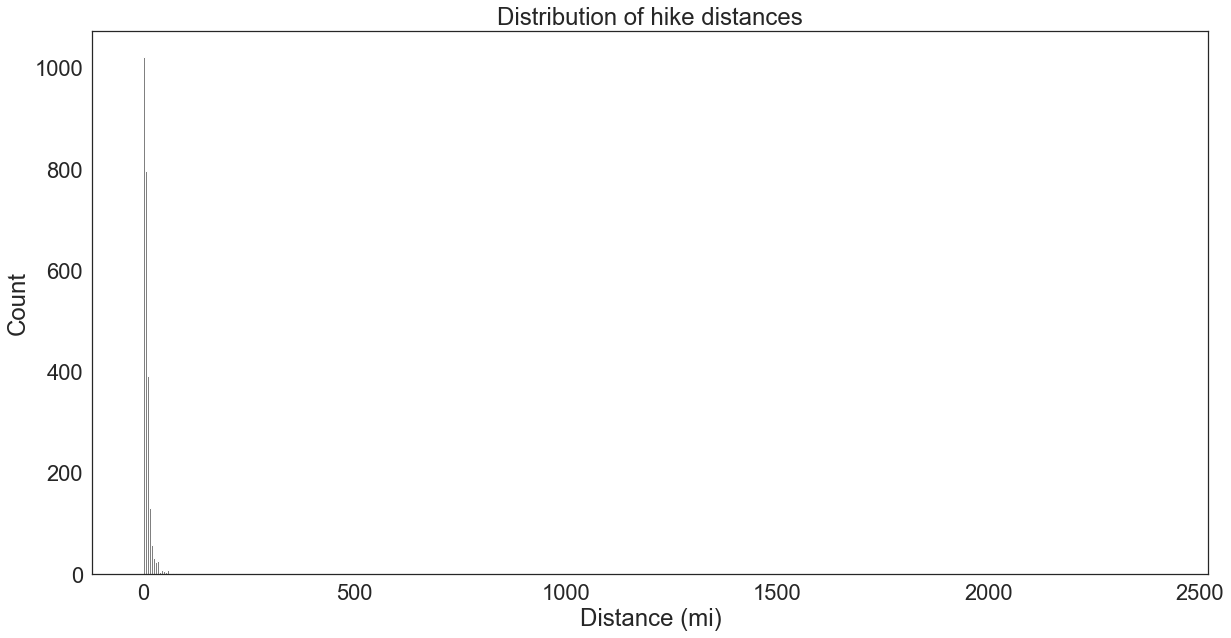

In [6]:
# plot distance
plt.hist(procdf['DIST_TOTAL'],bins=500,color='gray')
plt.title('Distribution of hike distances')
plt.xlabel('Distance (mi)')
plt.ylabel('Count')

Most hikes are fairly short, but there are a few super long trails that are outliers in the data, so I filter out hikes that are longer than 30 miles.

Text(0, 0.5, 'Count')

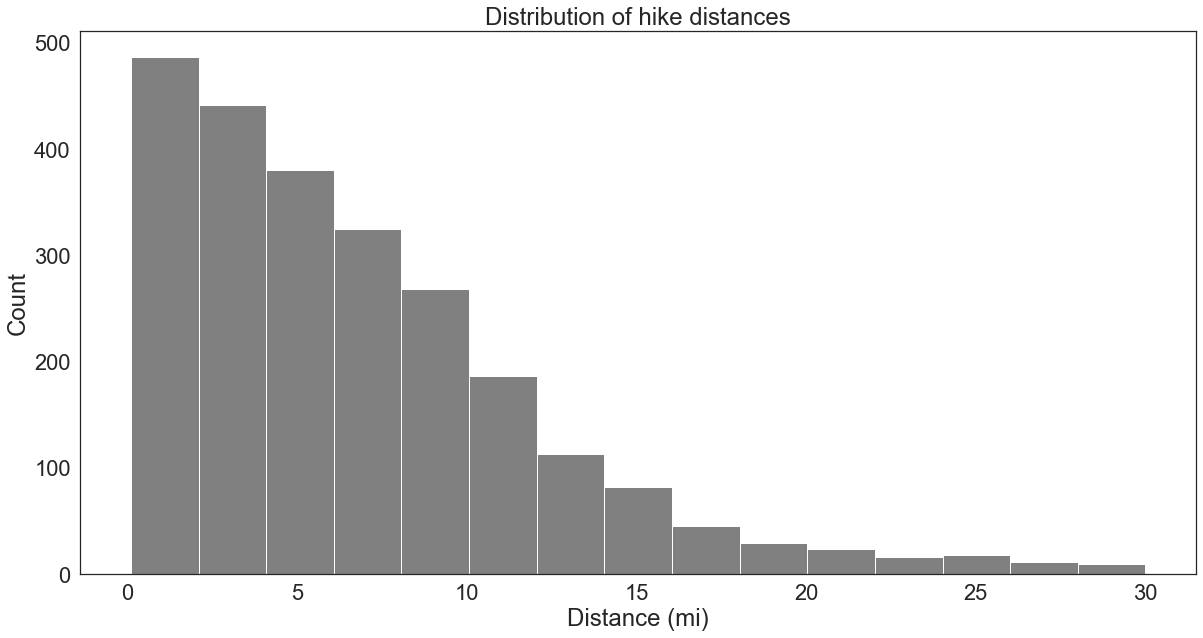

In [7]:
#filter out super long trails
upper_distance=30
lower_distance=0

#longest trails are through trails like the PCT-- would be safe to exclude these for dayhike-length trails
procdf=procdf.loc[(procdf['DIST_TOTAL']<=upper_distance)&(procdf['DIST_TOTAL']>=lower_distance),]
#plt.hist(procdf['DIST_TOTAL'])


#plot distance again
plt.hist(procdf['DIST_TOTAL'],bins=15,color='grey')
plt.title('Distribution of hike distances')
plt.xlabel('Distance (mi)')
plt.ylabel('Count')

This is now has a skewed normal distribution, and a much more reasonable scale.

Ratings are on a 1-5 scale, where trails with no ratings have a value of 0. Let's replace these values with NA.

Text(0, 0.5, 'Count')

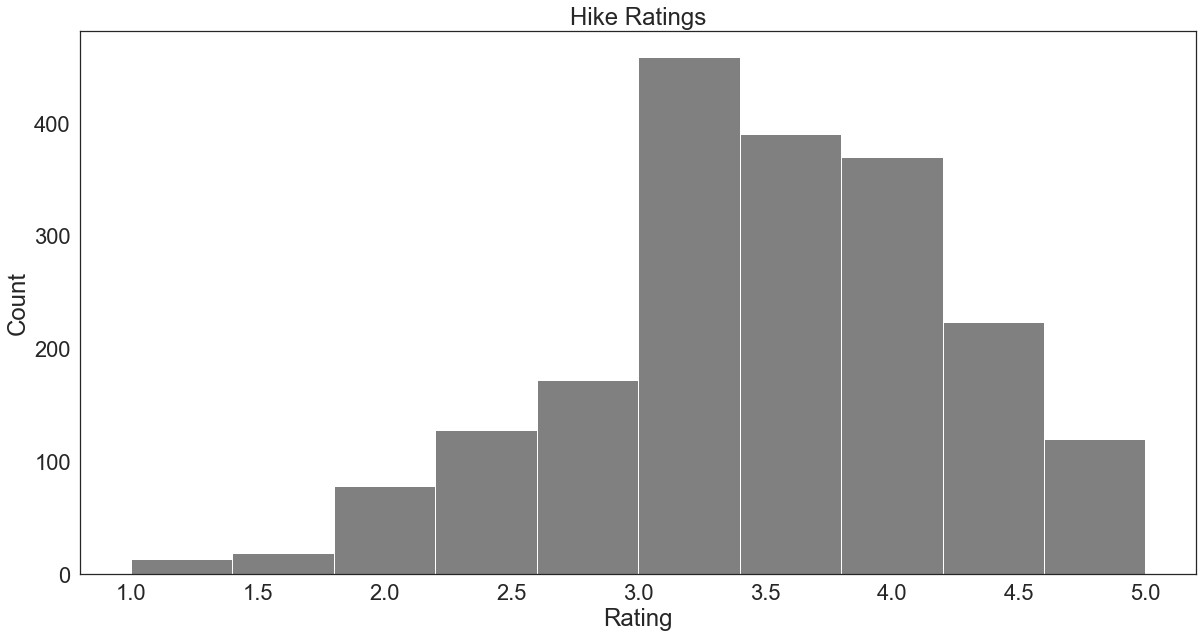

In [8]:
#rating - replace 0.0 with nan
procdf.loc[procdf['RATING']==0,'RATING']=np.nan
plt.hist(procdf['RATING'],color='grey')
plt.title('Hike Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

Most hikes have a rating between 3-4.




In [9]:
#report-date - drop variable
procdf=procdf.drop(axis=1,labels=['REPORT_DATE'])


In [10]:
#print(df.isnull().sum())
procdf.isnull().sum()

TITLE             0
REGION            0
GAIN            412
HIGHEST         440
RATING          463
RATING_COUNT      0
LATITUDE        118
LONGITUDE       118
REPORT_COUNT      0
URL               0
DIST_TOTAL        0
dtype: int64

After processing the data for each variable, there are still some rows with missing values for elevation, rating, and location data. I exclude hikes with missing location data, since that is a core requirement for spatial visualization. Missing values for other columns will be accounted for in future analyses. 

In [11]:
#dealing with nans:
##for now I think we can just ignore data with no location data
df = procdf.dropna(axis=0,subset=['LATITUDE','LONGITUDE'])

df=df.loc[df['LONGITUDE']<0,:]  #deal with some typos in longitude data
print("Cleaned dataset has", len(df.index),"hikes in it")


Cleaned dataset has 2319 hikes in it


In [12]:
#make a geospatial dataframe from the data 

#load in washington boundary 
wa=gpd.read_file("wa_data.gpkg", layer='wa_counties')

#make a geospatial dataframe from the data 

hikes = gpd.GeoDataFrame(df,
                         crs="EPSG:4326", 
                         geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE))

#subset to only hikes within washington
wa_hikes = gpd.sjoin(hikes, wa, op='within')
wa_hikes = wa_hikes.drop(['index_right'], axis=1)
wa_hikes.to_file("wa_data.gpkg", layer='hikes',driver='GPKG')

/Users/emilygrabowski/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


The final dataset still has over 2000 hikes in Washington in it. In the next section I'll show some exploratory analyses investigating the relationships between these variables and hike popularity

## Exploratory Analysis

In [13]:
#summary statistics for the dataset
wa_hikes.describe()

,GAIN,HIGHEST,RATING,RATING_COUNT,LATITUDE,LONGITUDE,REPORT_COUNT,DIST_TOTAL,OBJECTID,Shape_Length,Shape_Area
count,1888.000000,1875.000000,1875.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03,2.264000e+03
mean,1528.145127,3663.712000,3.492021,9.590106,47.489457,-121.458554,86.566254,6.936882,24.779152,1.577723e+06,6.142281e+10
std,1371.945241,2302.391488,0.755856,21.607531,0.801721,1.407757,190.833125,5.517149,13.211318,3.709110e+05,2.737611e+10
min,8.000000,10.000000,1.000000,0.000000,45.566905,-124.715667,0.000000,0.100000,1.000000,4.164473e+05,4.904647e+09
25%,378.750000,1541.000000,3.000000,2.000000,46.947829,-122.194638,8.000000,2.700000,12.000000,1.316131e+06,4.837491e+10
50%,1200.000000,3920.000000,3.500000,5.000000,47.530243,-121.639919,26.000000,6.000000,30.000000,1.700954e+06,6.029248e+10
75%,2400.000000,5593.500000,4.000000,9.000000,48.024986,-120.963359,80.000000,9.800000,37.000000,1.792175e+06,6.504531e+10
max,10000.000000,12276.000000,5.000000,339.000000,48.994636,-117.027635,2148.000000,30.000000,39.000000,2.251016e+06,1.480900e+11


In [14]:
#sns.scatterplot(hikes['RATING_COUNT'],hikes['REPORT_COUNT'])
print('The correlation between RATING_COUNT and REPORT_COUNT is:', round(stats.pearsonr(hikes['RATING_COUNT'],hikes['REPORT_COUNT'])[0],2))

The correlation between RATING_COUNT and REPORT_COUNT is: 0.93


Because of a strong correlation between report and rating count, I will use only report count in regression and other analyses.


Next, let's look at correlations between the main numeric variables in the dataset.

Text(0.5, 0.98, 'Pairwise Correlations of variables')

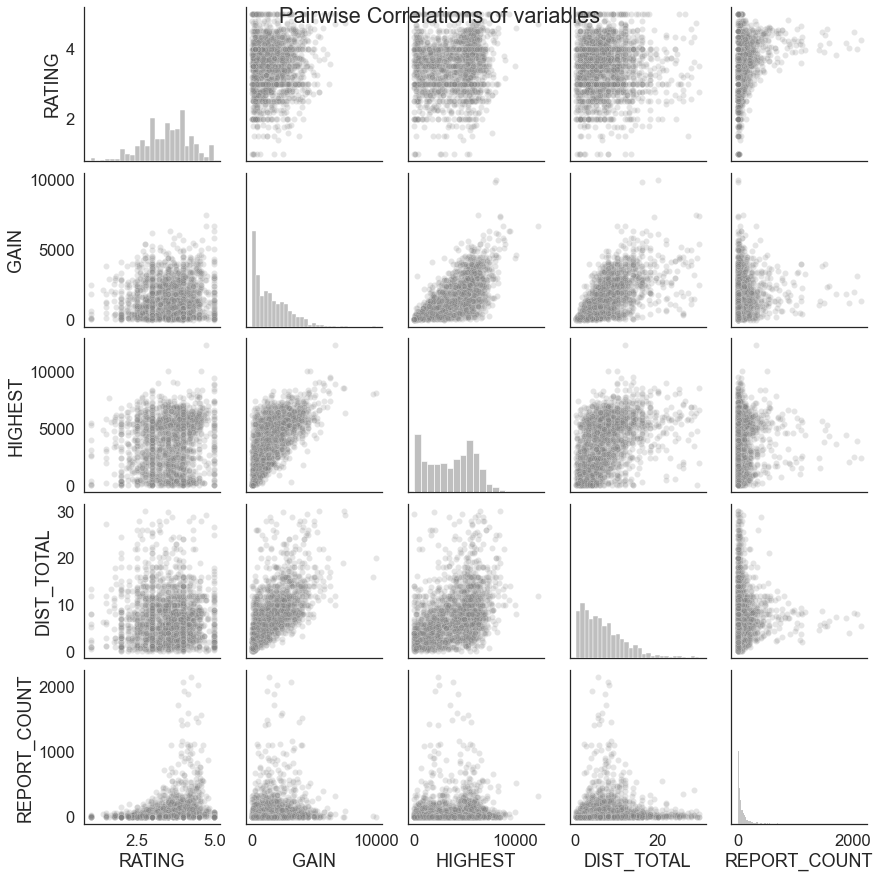

In [15]:
sns.set(font_scale=1.5,style='white')
scatter_df=wa_hikes[['RATING','GAIN','HIGHEST','DIST_TOTAL','REPORT_COUNT']]
ax=sns.pairplot(wa_hikes[['RATING','GAIN','HIGHEST','DIST_TOTAL','REPORT_COUNT']],
            plot_kws=dict(color="gray", alpha=.2),
            diag_kws=dict(color="gray", alpha=.5))
ax.fig.suptitle("Pairwise Correlations of variables")


It seems like there are correlations between the distance and elevation metrics. For example, longer trails seems to have more total elevation gain, which makes sense. In addition, Report Count, Total Distance, and Gain all appear to have log normal distributions, which suggests log-transformations for those variables in analysis 

### Visualizing popular hikes by region

It seems reasonable that the most popular hikes will be near the most populated region in the state: the greater Seattle/Bellevue area. Let's visualize the hikes based on report counts as our metric of popularity.

Text(0.5, 1.0, 'WTA hike popularity by region')

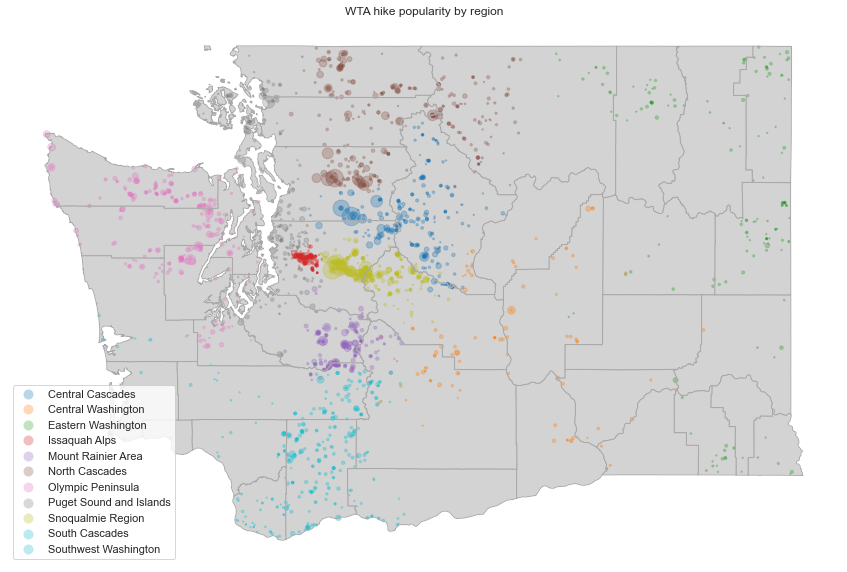

In [16]:
sns.set(font_scale=1,style='white')


#plot background
ax=wa.plot(color='lightgrey')
ax.axis('off')
wa.boundary.plot(ax=ax, color='darkgrey', lw=1)

#make a size feature based on RATING_COUNT
wa_hikes['size']=hikes['RATING_COUNT']+2

#plot hikes
wa_hikes.plot(ax=ax,column='REGION',markersize=wa_hikes['size'],alpha=.3,legend=True)

plt.title("WTA hike popularity by region")

Hikes with larger circles are more popular. Most popular hikes are centered around the Puget Sound region, which is the area near Seattle and surrounding cities. Interestingly, though, the region immediately surrounding Seattle does not have the most popular hikes. This can be quantified as in the table below.

In [17]:
wa_hikes['REGION'].value_counts()

wa_hikes.groupby(by='REGION').agg({'REPORT_COUNT':['mean',
                                                   'count',
                                                   'sum']}).sort_values(by=('REPORT_COUNT','mean'),
                                                                        ascending=False)

REPORT_COUNT             
                                mean count    sum
REGION                                           
Snoqualmie Region         216.799180   244  52899
North Cascades            113.285256   312  35345
Central Cascades          112.060729   247  27679
Mount Rainier Area        104.613861   202  21132
Issaquah Alps              81.395349   129  10500
Olympic Peninsula          80.979675   246  19921
Central Washington         44.156863   102   4504
Puget Sound and Islands    43.372263   274  11884
South Cascades             35.975845   207   7447
Southwest Washington       20.038168   131   2625
Eastern Washington         12.058824   170   2050

The areas with the highest average traffic per trail are the montainous regions close to the Puget sound: the North/Central cascades, Mount Rainier, and the Snoqualmie Region. Notably, the Puget Sound and Islands region (the region where Seattle is actually located) has much lower number of report counts. This indicates that it's not solely proximity to the city that influences hike popularity. 

## Predicting Popularity

While location is likely important, there are other factors that may influence popularity. Let's explore this with a mixed effects regression. 

**output variable**: REPORT_COUNT

**linear factors**: HIGHEST, GAIN, DIST_TOTAL, RATING

**random intercept**: REGION

In [18]:
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#plt.scatter(np.log(reg_hikes_df['GAIN']),np.log(reg_hikes_df['REPORT_COUNT']))
reg_hikes_df= wa_hikes[['GAIN','HIGHEST','DIST_TOTAL','RATING','REPORT_COUNT','REGION']]

#log transform report counts with laplace smoothing
reg_hikes_df['REPORT_COUNT']=np.log(reg_hikes_df['REPORT_COUNT']+1)

#impute undefined rows
imp=SimpleImputer()
imp_reg_hikes_df=imp.fit_transform(reg_hikes_df.drop('REGION',axis=1))

#scale variables using a standard scaler
stdscaler=StandardScaler()
reg_df=pd.DataFrame(stdscaler.fit_transform(imp_reg_hikes_df))
reg_df.columns =['GAIN','HIGHEST','DIST_TOTAL','RATING','REPORT_COUNT']

#add region back in
reg_df['REGION']=reg_hikes_df.reset_index()['REGION']

#fit model and print summary
md = smf.mixedlm('REPORT_COUNT ~ HIGHEST+ GAIN+ DIST_TOTAL + RATING', 
                 reg_df, groups=reg_df['REGION'])
mdf = md.fit()
print(mdf.summary())


/Users/emilygrabowski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: REPORT_COUNT
No. Observations: 2264    Method:             REML        
No. Groups:       11      Scale:              0.7641      
Min. group size:  102     Log-Likelihood:     -2939.4349  
Max. group size:  312     Converged:          Yes         
Mean group size:  205.8                                   
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept   -0.046     0.131  -0.351  0.726  -0.302   0.211
HIGHEST     -0.032     0.029  -1.127  0.260  -0.089   0.024
GAIN        -0.004     0.028  -0.125  0.900  -0.059   0.052
DIST_TOTAL   0.069     0.023   3.030  0.002   0.024   0.114
RATING       0.269     0.019  14.379  0.000   0.232   0.306
Group Var    0.184     0.097                               



Results:


**HIGHEST**: n.s

**GAIN**: n.s.

**DIST_TOTAL**: Longer trails result in higher report counts

**RATING**: Higher rated trails have more traffic

Results indicate that independent of certain geographic factors, other factors appear to influence hike traffic. This opens up more research avenues in the future, including how other factors that may affect popularity, including accessibility, social media presence, and other potential influences. 

## Identifying Hike Neighborhoods

The regions in the dataset are defined in the original dataset by WTA. Another option is to allow the data to generate regions based on the clustering of trails in a small area. Using the OPTICS clustering algorithm, which is good for clusters of various densities, I identify data-driven regional assignments for these trails.

In [22]:
from sklearn.preprocessing import MinMaxScaler

#select and scale the data
scaler=MinMaxScaler()
cluster_df = wa_hikes[['HIGHEST','LATITUDE','LONGITUDE']].dropna()
X=scaler.fit_transform(cluster_df[['LATITUDE','LONGITUDE','HIGHEST']])


The algorithm identified 23 clusters.
Proportion of noise points 0.5536


Text(0.5, 1.0, 'Clustered Hikes')

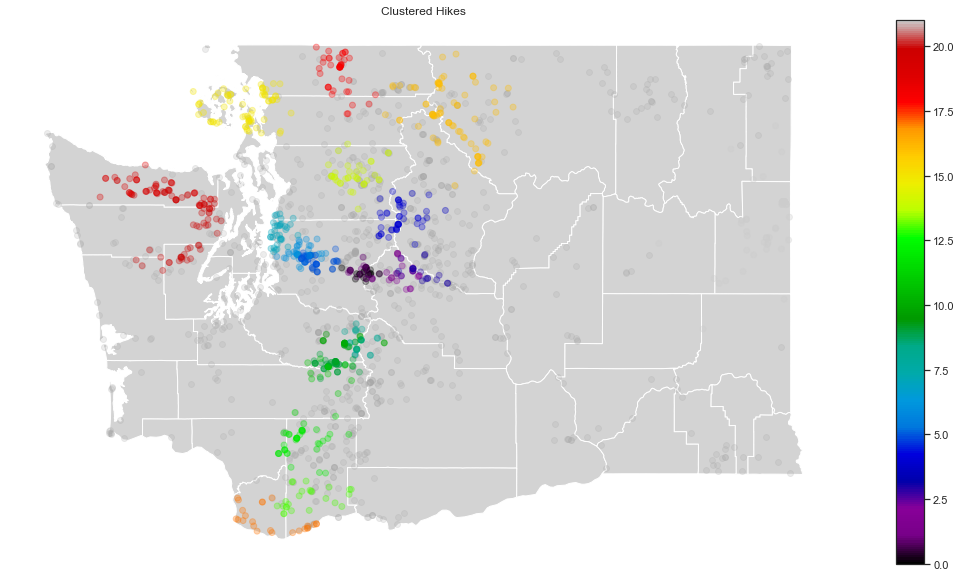

In [23]:
from sklearn.cluster import OPTICS

#fit model
model = OPTICS(min_samples=18,metric='minkowski',
                               xi=.0001,
                               cluster_method='xi').fit(X)

cluster_df['CLUSTER'] = model.labels_
print('The algorithm identified',len(cluster_df['CLUSTER'].unique()-1),'clusters.')
print("Proportion of noise points",cluster_df.loc[cluster_df['CLUSTER']==-1,:].shape[0]/cluster_df.shape[0])



#plot background
ax=wa.plot(color='lightgrey')
ax.axis('off')

#plot noisy points
noise=cluster_df.loc[cluster_df['CLUSTER']==-1,:]
noise = gpd.GeoDataFrame(noise,
                         crs="EPSG:4326", 
                         geometry=gpd.points_from_xy(noise.LONGITUDE, noise.LATITUDE))
noise.plot(ax=ax,alpha=.2,legend=True,color='darkgrey')


#plot clusters
non_noise_clusters=cluster_df.loc[cluster_df['CLUSTER']!=-1,:]
hikes_clustered = gpd.GeoDataFrame(non_noise_clusters,
                         crs="EPSG:4326", 
                         geometry=gpd.points_from_xy(non_noise_clusters.LONGITUDE, non_noise_clusters.LATITUDE))
hikes_clustered.plot(ax=ax,alpha=.3,legend=True,column='CLUSTER',cmap='nipy_spectral')

plt.title("Clustered Hikes")

About half the points are clustered into cluster centers based on the OPTICS algorithm. Other points are determined as noise. These identified clusters are hot-spots for hikes, including hikes that are close together geographically and at a similar elevation.

Ths indicates bottom-up assessment of hikes and clustering identifies local hotspots. This is at a much more granular scale than the origional variable REGION. 

Most hotspots are located in the Puget Sound area and along the Cascade mountain range. In addition, many hotspots are identified in the I-90 corridor (purple and blue) area just outside of the Seattle area. This highlights how accessibility of an area influences the density of trails, which may in turn affect traffic through that area. 

## Next Steps

- Visualize hike distribution along road and land management layers
- Scrape and process trip report narratives for additional context on trail conditions
- Model and predict trip popularity as a function of social, geographical, and physical variables.